Using device: cuda:0
Training with mixed precision (AMP)…
Epoch [1/10] - Train Loss: 0.2694, Train Acc: 94.89% - Val Loss: 0.1315, Val Acc: 95.16% - LR: 0.001000
Saved best model (Val Acc: 95.16%)
Epoch [2/10] - Train Loss: 0.1286, Train Acc: 97.59% - Val Loss: 0.0380, Val Acc: 98.22% - LR: 0.001000
Saved best model (Val Acc: 98.22%)
Epoch [3/10] - Train Loss: 0.1137, Train Acc: 98.28% - Val Loss: 0.0465, Val Acc: 98.41% - LR: 0.001000
Saved best model (Val Acc: 98.41%)
Epoch [4/10] - Train Loss: 0.0880, Train Acc: 98.18% - Val Loss: 0.0440, Val Acc: 98.66% - LR: 0.001000
Saved best model (Val Acc: 98.66%)
Epoch [5/10] - Train Loss: 0.0781, Train Acc: 98.02% - Val Loss: 0.0629, Val Acc: 98.34% - LR: 0.001000
Epoch [6/10] - Train Loss: 0.0622, Train Acc: 97.07% - Val Loss: 0.0584, Val Acc: 97.96% - LR: 0.001000
Epoch [7/10] - Train Loss: 0.0743, Train Acc: 97.57% - Val Loss: 0.0733, Val Acc: 97.77% - LR: 0.001000
Epoch [8/10] - Train Loss: 0.0680, Train Acc: 97.97% - Val Loss: 0.0759, V

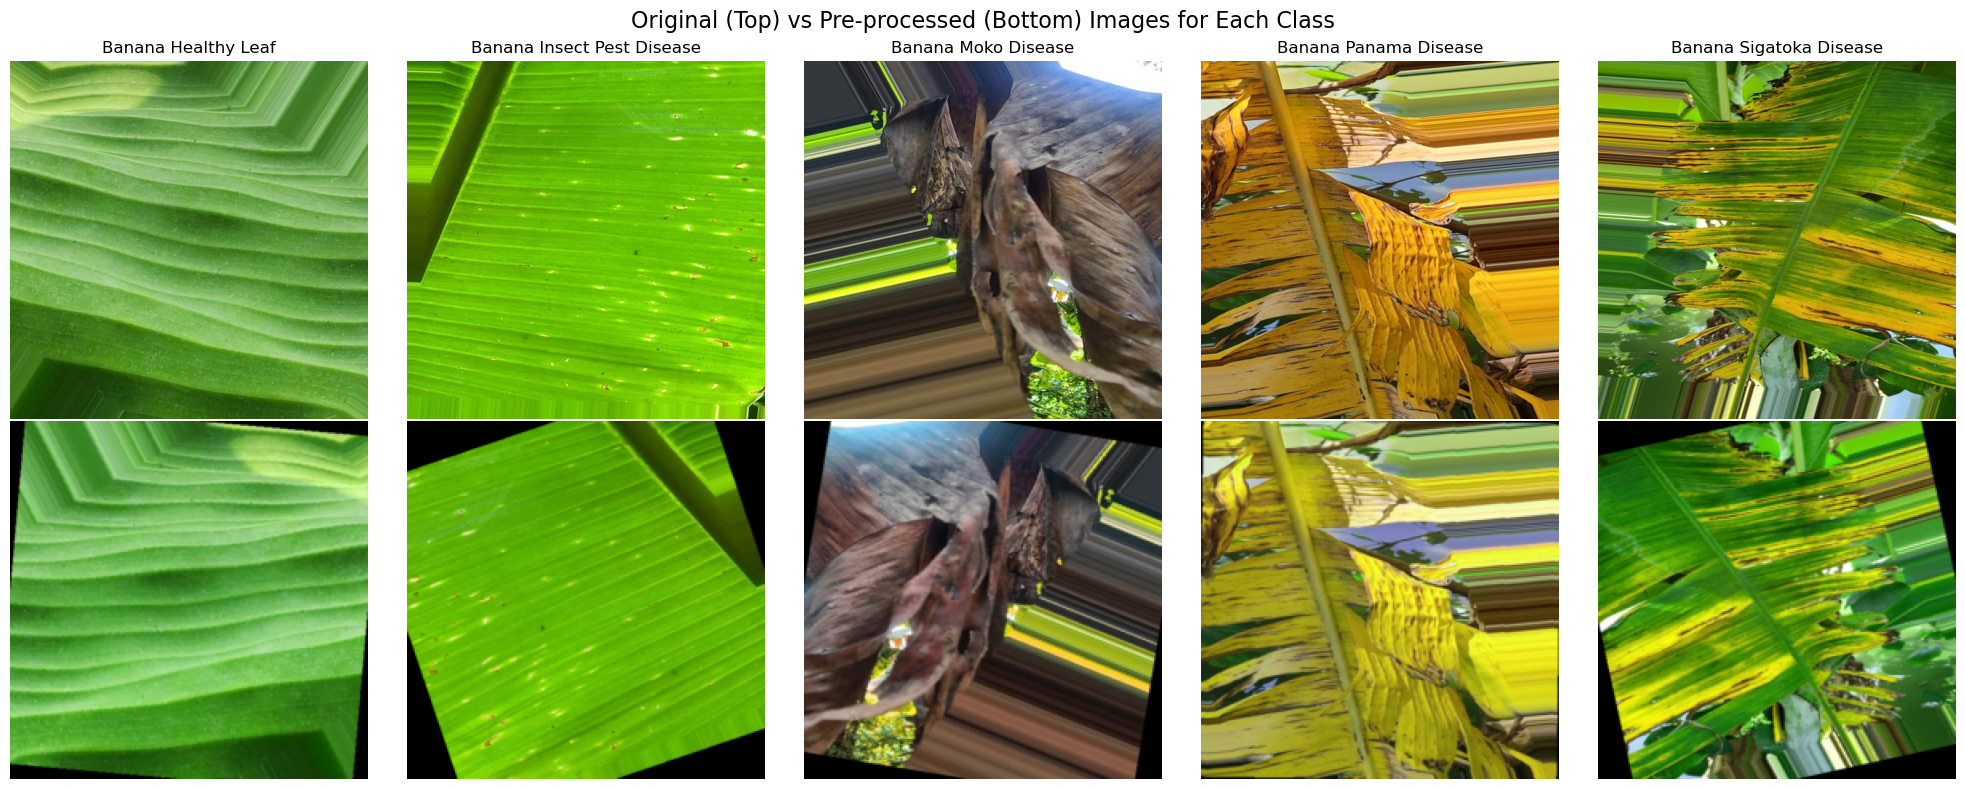

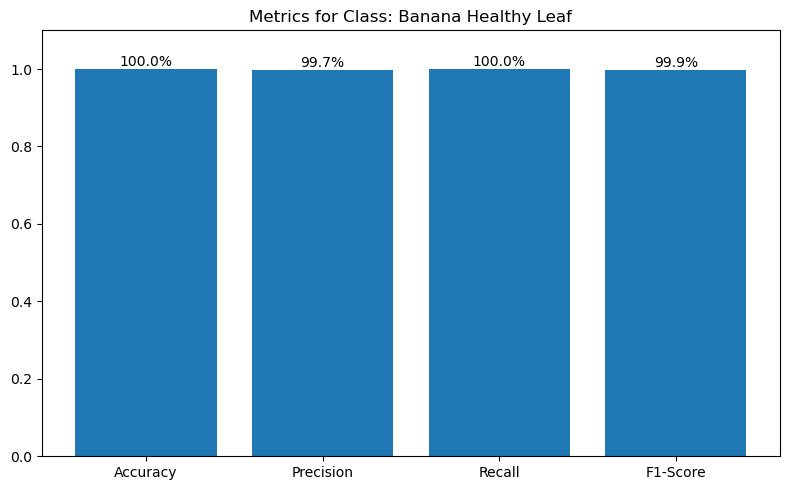

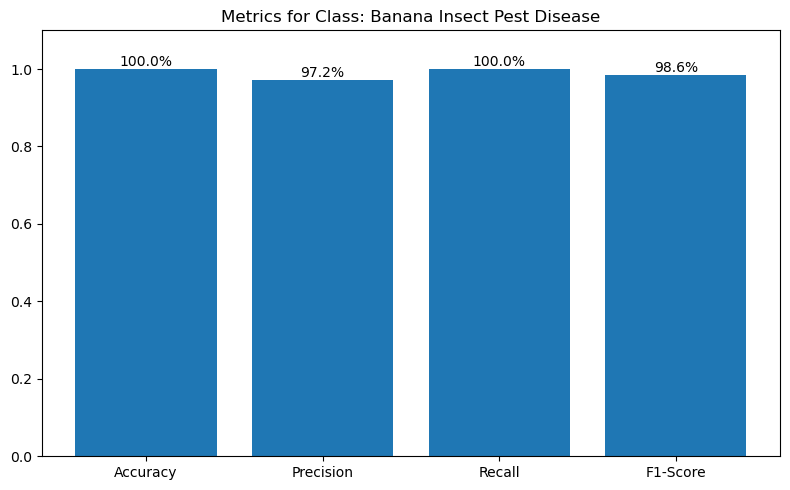

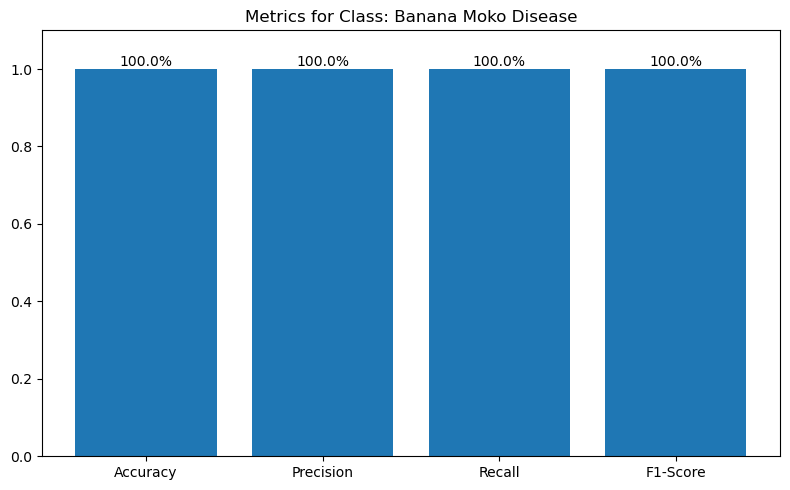

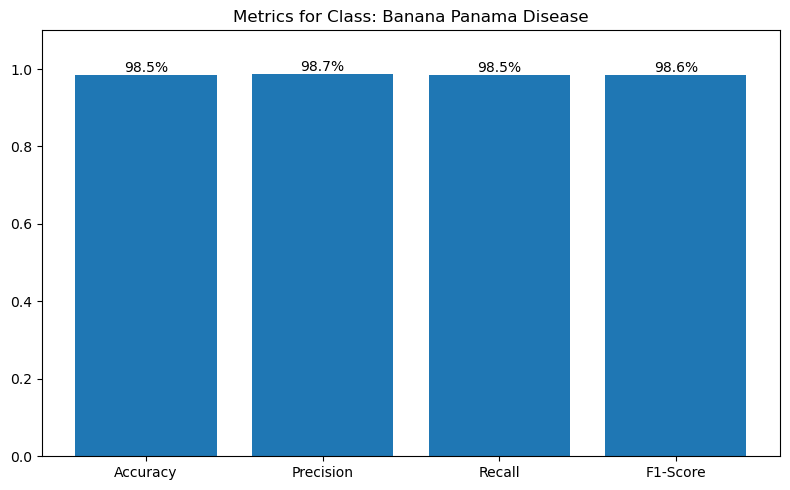

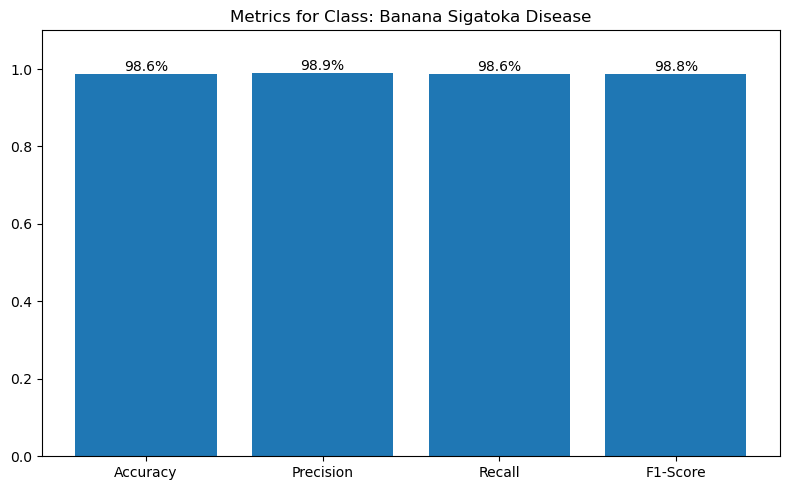

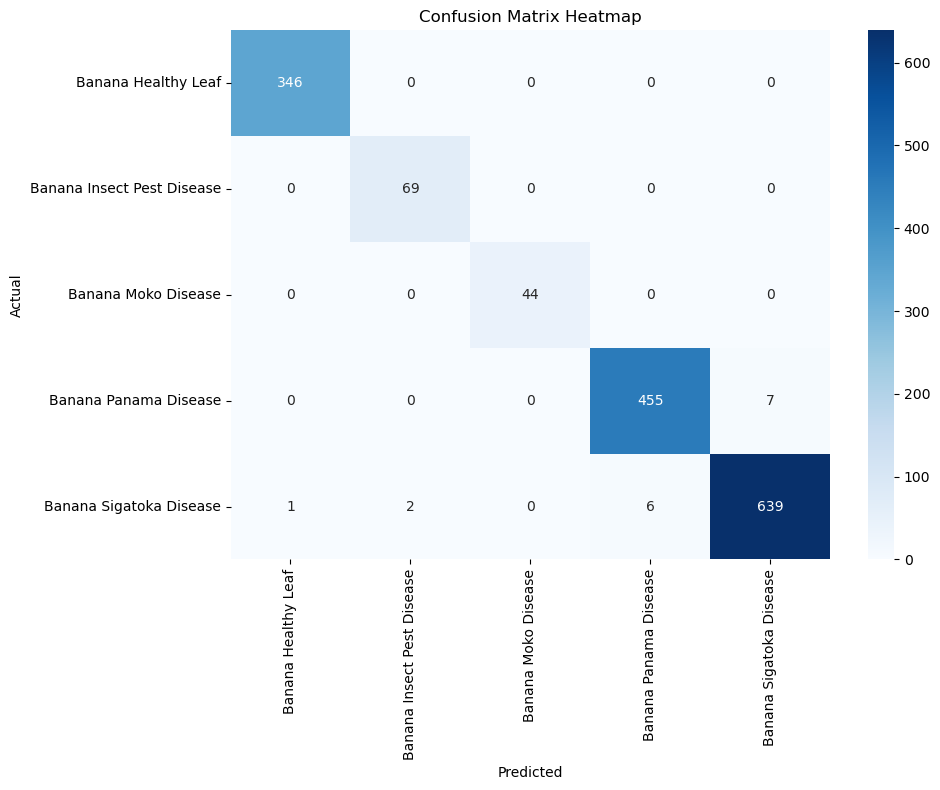

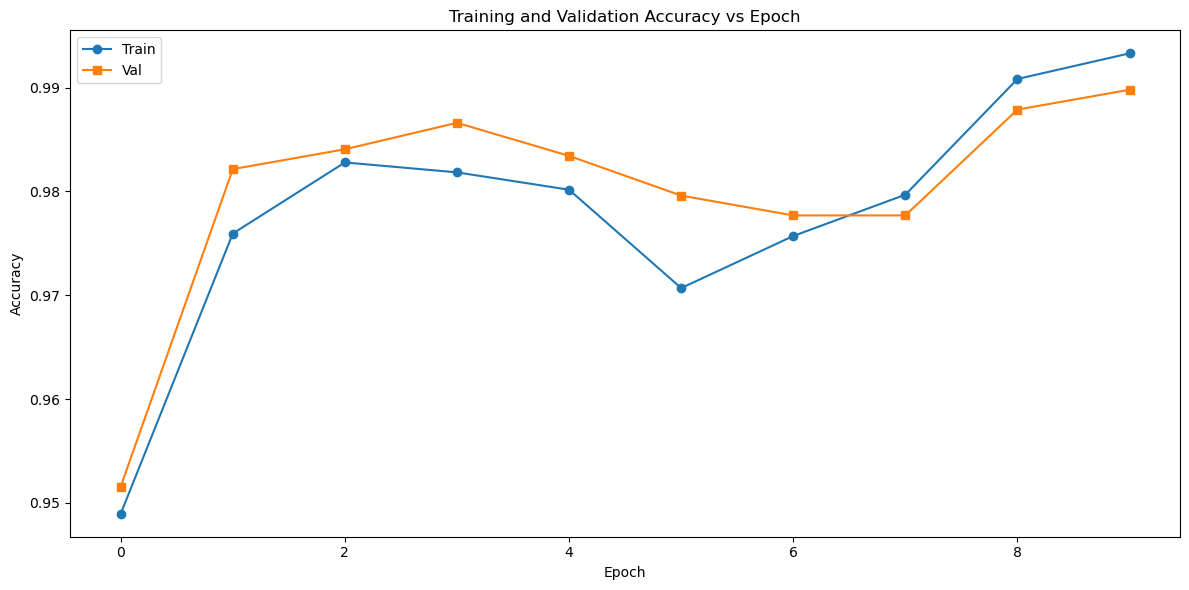

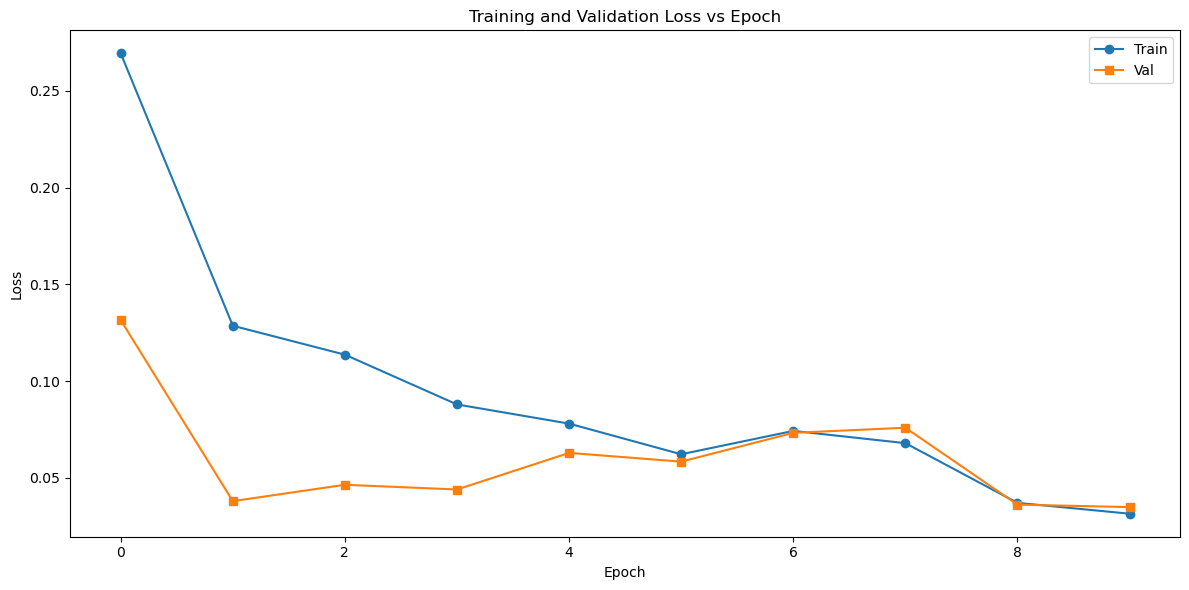

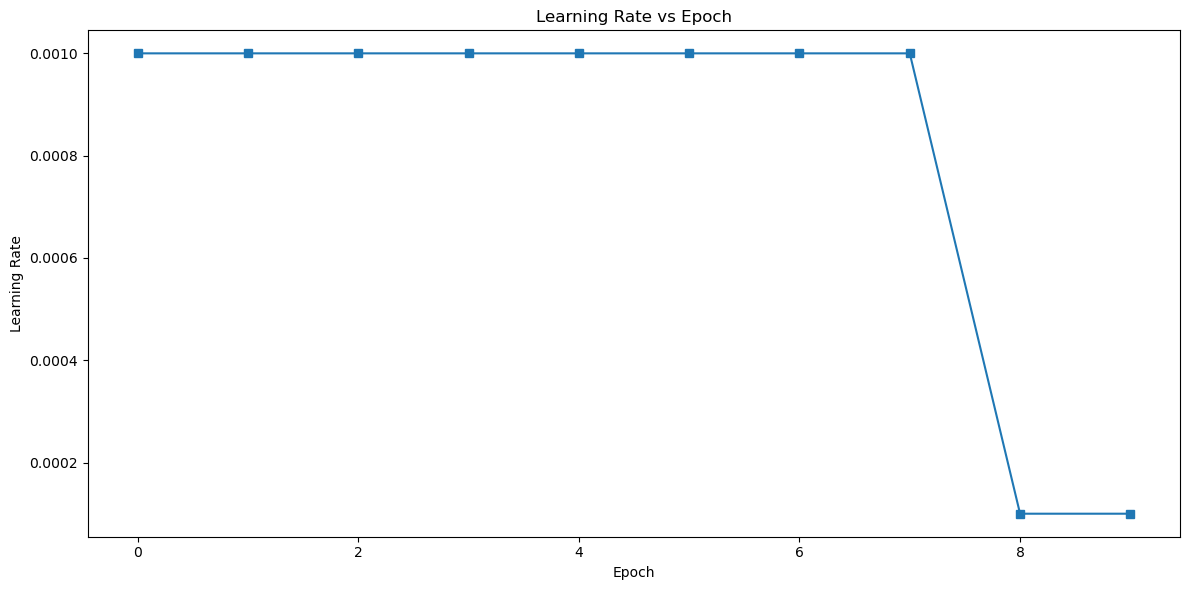

In [5]:
import os 
import time
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from torch.amp import GradScaler, autocast

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Dataset Class with CLAHE pre-processing
class BananaDiseaseDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        orig_image = cv2.imread(self.image_paths[idx])
        orig_image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
        image = self.apply_clahe(orig_image.copy())

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

    def apply_clahe(self, image):
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        cl = clahe.apply(l)
        limg = cv2.merge((cl, a, b))
        return cv2.cvtColor(limg, cv2.COLOR_Lab2RGB)

# Transforms
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Accuracy & validation functions
def compute_train_accuracy(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            with autocast(device_type=device.type):
                outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    model.train()
    return accuracy_score(all_labels, all_preds)


def validate_model(model, loader, criterion):
    model.eval()
    all_preds, all_labels = [], []
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            with autocast(device_type=device.type):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    model.train()
    avg_loss = running_loss / len(loader)
    acc = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    return acc, avg_loss, cm, all_labels, all_preds

# Visualization helpers (unchanged) ...
def display_original_and_preprocessed_images(image_paths, labels, transform, class_names):
    num_classes = len(class_names)
    fig, axes = plt.subplots(2, num_classes, figsize=(4*num_classes, 8))
    fig.suptitle("Original (Top) vs Pre-processed (Bottom) Images for Each Class", fontsize=16)
    for i, class_name in enumerate(class_names):
        idx = next((j for j, lbl in enumerate(labels) if lbl == i), None)
        if idx is None: continue
        orig = cv2.cvtColor(cv2.imread(image_paths[idx]), cv2.COLOR_BGR2RGB)
        axes[0, i].imshow(orig); axes[0, i].set_title(class_name); axes[0, i].axis('off')
        proc = transform(orig.copy()).permute(1,2,0).numpy()
        proc = proc * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
        proc = np.clip(proc, 0, 1)
        axes[1, i].imshow(proc); axes[1, i].axis('off')
    plt.tight_layout(); plt.show()

def compute_class_metrics(cm):
    num_classes = cm.shape[0]
    class_accuracy = np.zeros(num_classes)
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1 = np.zeros(num_classes)
    for i in range(num_classes):
        TP = cm[i,i]
        FP = cm[:,i].sum() - TP
        FN = cm[i,:].sum() - TP
        class_accuracy[i] = TP/(cm[i,:].sum()+1e-6)
        precision[i] = TP/(TP+FP+1e-6)
        recall[i] = TP/(TP+FN+1e-6)
        f1[i] = 2*precision[i]*recall[i]/(precision[i]+recall[i]+1e-6)
    return class_accuracy, precision, recall, f1

def plot_class_wise_metrics(cm, class_names):
    acc, prec, rec, f1 = compute_class_metrics(cm)
    metrics = ['Accuracy','Precision','Recall','F1-Score']
    for i, name in enumerate(class_names):
        vals = [acc[i], prec[i], rec[i], f1[i]]
        plt.figure(figsize=(8,5))
        bars = plt.bar(metrics, vals)
        for bar in bars:
            h = bar.get_height()
            plt.text(bar.get_x()+bar.get_width()/2, h, f'{h:.1%}', ha='center', va='bottom')
        plt.title(f'Metrics for Class: {name}'); plt.ylim(0,1.1)
        plt.tight_layout(); plt.show()

def plot_confusion_matrix_heatmap(cm, class_names):
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix Heatmap')
    plt.tight_layout(); plt.show()

def plot_learning_rate_vs_epoch(lrs):
    plt.figure(figsize=(12,6))
    plt.plot(lrs, marker='s')
    plt.xlabel('Epoch'); plt.ylabel('Learning Rate'); plt.title('Learning Rate vs Epoch')
    plt.tight_layout(); plt.show()

def plot_accuracy_vs_epoch(train_accs, val_accs):
    plt.figure(figsize=(12,6))
    plt.plot(train_accs, marker='o')
    plt.plot(val_accs, marker='s')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Training and Validation Accuracy vs Epoch')
    plt.legend(['Train','Val'])
    plt.tight_layout(); plt.show()

def plot_loss_vs_epoch(train_losses, val_losses):
    plt.figure(figsize=(12,6))
    plt.plot(train_losses, marker='o')
    plt.plot(val_losses, marker='s')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training and Validation Loss vs Epoch')
    plt.legend(['Train','Val'])
    plt.tight_layout(); plt.show()

def main():
    # Paths to train & val directories
    train_dir = r"G:\Mega_Project\Dataset\5_Classes_TVT\train"
    val_dir   = r"G:\Mega_Project\Dataset\5_Classes_TVT\val"

    # Gather image paths & labels
    def load_dataset(folder):
        paths, labels = [], []
        class_names = sorted([d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder, d))])
        for lbl, cls in enumerate(class_names):
            cls_folder = os.path.join(folder, cls)
            for fname in os.listdir(cls_folder):
                if fname.lower().endswith(('png','jpg','jpeg')):
                    paths.append(os.path.join(cls_folder, fname))
                    labels.append(lbl)
        return paths, labels, class_names

    train_paths, train_labels, class_names = load_dataset(train_dir)
    val_paths, val_labels, _                = load_dataset(val_dir)

    # DataLoaders
    train_dataset = BananaDiseaseDataset(train_paths, train_labels, transform=train_transform)
    val_dataset   = BananaDiseaseDataset(val_paths,   val_labels,   transform=val_transform)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False)

    # Class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

    # Model
    num_classes   = len(class_names)
    dropout_rate  = 0.3

    # ---- Fixed MobileNetV2 instantiation ----
    model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
    # Replace classifier head
    in_feats = model.last_channel
    model.classifier = nn.Sequential(
        nn.Dropout(p=dropout_rate),
        nn.Linear(in_feats, num_classes)
    )

    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    # Un-freeze the last inverted-residual blocks (features[15]–features[18])
    for i in range(15, 19):
        for param in model.features[i].parameters():
            param.requires_grad = True

    # Un-freeze classifier head
    for param in model.classifier.parameters():
        param.requires_grad = True

    model = model.to(device)

    # Loss, optimizer, scheduler, scaler
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3)
    scaler    = GradScaler()

    num_epochs = 10
    best_accuracy, best_cm = 0.0, None
    all_train_accuracies, all_val_accuracies = [], []
    all_learning_rates, all_train_losses, all_val_losses = [], [], []

    print("Training with mixed precision (AMP)…")
    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, lbls in train_loader:
            inputs, lbls = inputs.to(device), lbls.to(device)
            optimizer.zero_grad()
            with autocast(device_type=device.type):
                outputs = model(inputs)
                loss = criterion(outputs, lbls)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        all_train_losses.append(avg_train_loss)
        all_learning_rates.append(optimizer.param_groups[0]['lr'])

        train_acc = compute_train_accuracy(model, train_loader)
        all_train_accuracies.append(train_acc)

        # ---- Unpack the extra returns here ----
        val_acc, avg_val_loss, cm_epoch, _, _ = validate_model(model, val_loader, criterion)
        all_val_accuracies.append(val_acc)
        all_val_losses.append(avg_val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc*100:.2f}% - "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc*100:.2f}% - "
              f"LR: {optimizer.param_groups[0]['lr']:.6f}")

        scheduler.step(val_acc)
        if val_acc > best_accuracy:
            best_accuracy = val_acc
            best_cm = cm_epoch
            torch.save(model.state_dict(), "BDD_CNN_Original-MobileNetv2.pth")
            print(f"Saved best model (Val Acc: {best_accuracy*100:.2f}%)")

    # ---- Updated time printing ----
    end_time = time.time()
    total_seconds = end_time - start_time

    hrs = int(total_seconds // 3600)
    mins = int((total_seconds % 3600) // 60)
    secs = int(total_seconds % 60)

    print(f"\nTotal training time: {hrs}h {mins}m {secs}s")
    print(f"Best Validation Accuracy: {best_accuracy*100:.2f}%")

    # ---- Overall Validation Metrics ----
    model.eval()
    labels_arr, preds_arr = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            labels_arr.extend(labels.cpu().numpy())
            preds_arr.extend(preds.cpu().numpy())

    prec = precision_score(labels_arr, preds_arr, average='macro')
    rec  = recall_score(   labels_arr, preds_arr, average='macro')
    f1   = f1_score(       labels_arr, preds_arr, average='macro')

    print("\nOverall Validation Metrics:")
    print(f"  Accuracy : {best_accuracy*100:.2f}%")
    print(f"  Precision: {prec*100:.2f}%")
    print(f"  Recall   : {rec*100:.2f}%")
    print(f"  F1‑Score : {f1*100:.2f}%")

    # Visualizations
    display_original_and_preprocessed_images(train_paths, train_labels, train_transform, class_names)
    plot_class_wise_metrics(best_cm, class_names)
    plot_confusion_matrix_heatmap(best_cm, class_names)
    plot_accuracy_vs_epoch(all_train_accuracies, all_val_accuracies)
    plot_loss_vs_epoch(all_train_losses, all_val_losses)
    plot_learning_rate_vs_epoch(all_learning_rates)


if __name__ == "__main__":
    main()
